In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2025-04-13 08:53:22.492098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744534402.682196      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744534402.735235      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=6373343b2e4e61dd9d6e9b657921c0c8ec4c1e117b299d49618d5029cc92410b
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [3]:
data = pd.read_csv('/kaggle/input/eurusd60/EURUSD-60-DS.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45768,1.45785,12957.8500
1,01.01.2008 03:00:00.000,1.45788,1.45803,1.45754,1.45770,8374.1500
2,01.01.2008 04:00:00.000,1.45770,1.45987,1.45766,1.45913,11715.2595
3,01.01.2008 05:00:00.000,1.45916,1.45946,1.45854,1.45893,20694.8375
4,01.01.2008 06:00:00.000,1.45973,1.45984,1.45892,1.45962,26844.9970


In [4]:
# import pandas_ta as ta
# data['RSI_14'] = ta.rsi(data['Close'], length=14)
# data['MA20'] = ta.ema(data['Close'], length=20)
# data['MACD'] = ta.macd(data['Close'])['MACD_12_26_9']
# data['ATR_14'] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
# bb = ta.bbands(data['Close'], length=20)
# data['BB_upper'] = bb['BBU_20_2.0']
# data['BB_lower'] = bb['BBL_20_2.0']
# data['Stoch_K'] = ta.stoch(data['High'], data['Low'], data['Close'])['STOCHk_14_3_3']
# data['CCI_20'] = ta.cci(data['High'], data['Low'], data['Close'], length=20)
# data['adx_14'] = data.ta.adx(length=14)['ADX_14']
# data['Candle_Range'] = data['High'] - data['Low']
# data['Candle_Body'] = data['Close'] - data['Open']
# data['Price_Change'] = (data['Close'] - data['Open']) / data['Open']
# data['Stoch_D'] = ta.stoch(data['High'], data['Low'], data['Close'])['STOCHd_14_3_3']
# data = data.dropna()
# data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S.%f')
# data['Hour_of_Day'] = data['Date'].dt.hour
# data['Day_of_Week'] = data['Date'].dt.dayofweek

# data = data.dropna()

import pandas as pd
import pandas_ta as ta
import numpy as np

data['RSI_14'] = ta.rsi(data['Close'], length=14)

# تعریف تابع برای محاسبه میانگین وزن‌دار
def weighted_moving_average(series, window):
    weights = np.arange(1, window + 1)  # وزن‌های خطی: [1, 2, ..., window]
    return series.rolling(window).apply(lambda x: np.sum(x * weights) / weights.sum(), raw=True)

# تنظیم تعداد روزهای گذشته (پنجره)
n = 16  # می‌توانید این مقدار را تغییر دهید

# محاسبه میانگین وزن‌دار برای OHLC
data['WMA_Open'] = weighted_moving_average(data['Open'], n)
data['WMA_High'] = weighted_moving_average(data['High'], n)
data['WMA_Low'] = weighted_moving_average(data['Low'], n)
data['WMA_Close'] = weighted_moving_average(data['Close'], n)

# تبدیل ستون Date به فرمت datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S.%f')

# استخراج Hour_of_Day و Day_of_Week
data['Hour_of_Day'] = data['Date'].dt.hour
data['Day_of_Week'] = data['Date'].dt.dayofweek

# نگه‌داشتن فقط ستون‌های مورد نیاز
data = data[['Date', 'Open', 'High', 'Low', 'Close', 
             'RSI_14', 
             'WMA_Open', 'WMA_High', 'WMA_Low', 'WMA_Close', 
             'Hour_of_Day', 'Day_of_Week']]

# حذف ردیف‌های دارای NaN
data = data.dropna()

data.head()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Date,Open,High,Low,Close,RSI_14,WMA_Open,WMA_High,WMA_Low,WMA_Close,Hour_of_Day,Day_of_Week
15,2008-01-01 17:00:00,1.45880,1.45927,1.45823,1.45897,56.008740,1.458863,1.459312,1.458324,1.458837,17,1
16,2008-01-01 18:00:00,1.45845,1.45956,1.45844,1.45890,54.992378,1.458821,1.459334,1.458346,1.458851,18,1
17,2008-01-01 19:00:00,1.45898,1.46107,1.45860,1.46089,71.066637,1.458841,1.459535,1.458381,1.459091,19,1
18,2008-01-01 20:00:00,1.46085,1.46174,1.45784,1.45815,46.461704,1.459073,1.459793,1.458319,1.458985,20,1
19,2008-01-01 21:00:00,1.45873,1.45873,1.45718,1.45844,48.494267,1.459032,1.459683,1.458178,1.458920,21,1


In [5]:
input_features = [ 'Open', 'High', 'Low', 'Close', 
             'RSI_14', 
             'WMA_Open', 'WMA_High', 'WMA_Low', 'WMA_Close', 
             'Hour_of_Day']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['Open', 'High', 'Low', 'Close']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))
if len(scaled_inputs.shape) > 2:
    scaled_inputs = scaled_inputs.reshape(scaled_inputs.shape[0], scaled_inputs.shape[1])
if len(scaled_outputs.shape) > 2:
    scaled_outputs = scaled_outputs.reshape(scaled_outputs.shape[0], scaled_outputs.shape[1])

In [6]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)


In [7]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 84745
تعداد نمونه‌های Validation: 10593
تعداد نمونه‌های Test: 10594


In [16]:
del model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# def FLF(yTrue, yPred):
#     lam = 0.01
#     v = Lambda(lambda x: x * 0.99)(K.abs(yTrue - yPred))
#     vn = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 1] + yTrue[:, 2]) / 2 - (yPred[:, 1] + yPred[:, 2]) / 2))
#     vn1 = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 0] + yTrue[:, 3]) / 2 - (yPred[:, 0] + yPred[:, 3]) / 2))
#     # خطای ترکیبی فعلی
#     vx = K.square((v[:, 0] - vn1))
#     vy = K.square((v[:, 1] - vn))
#     vz = K.square((v[:, 2] - vn))
#     v4 = K.square((v[:, 3] - vn1))
#     # اضافه کردن خطای مستقیم High و Low
#     vy_direct = K.square(v[:, 1])  # خطای مستقیم High
#     vz_direct = K.square(v[:, 2])  # خطای مستقیم Low
#     # ترکیب همه خطاها
#     vm = K.concatenate([vx, vy, vz, v4, vy_direct, vz_direct])
#     vmx = K.mean(vm)
#     return vmx

from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
import tensorflow as tf

def FLF_with_direction(yTrue, yPred):
    lam = 0.01
    direction_weight = 0.2  # وزن خطای جهت

    # خطای magnitude
    v = Lambda(lambda x: x * 0.9)(K.abs(yTrue - yPred))
    # اضافه کردن K.epsilon() برای جلوگیری از مقادیر خیلی کوچک
    vn = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 1] + yTrue[:, 2]) / 2 - (yPred[:, 1] + yPred[:, 2]) / 2 + K.epsilon()))
    vn1 = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 0] + yTrue[:, 3]) / 2 - (yPred[:, 0] + yPred[:, 3]) / 2 + K.epsilon()))
    vx = K.square(v[:, 0] - vn1)
    vy = K.square(v[:, 1] - vn)
    vz = K.square(v[:, 2] - vn)
    v4 = K.square(v[:, 3] - vn1)
    vy_direct = K.square(v[:, 1])
    vz_direct = K.square(v[:, 2])

    # ترکیب خطاها
    vm = K.concatenate([vx, vy, vz, v4, vy_direct, vz_direct])
    vmx = K.mean(vm)

    # محاسبه جهت تغییرات Close
    true_direction = K.sign(yTrue[1:, 3] - yTrue[:-1, 3] + K.epsilon())
    pred_direction = K.sign(yPred[1:, 3] - yPred[:-1, 3] + K.epsilon())
    
    # خطای جهت
    direction_error = K.abs(true_direction - pred_direction)
    direction_loss = K.mean(direction_error) * direction_weight

    # ترکیب همه خطاها
    total_loss = vmx + direction_loss

    # جلوگیری از nan با استفاده از tf.math.is_nan
    total_loss = tf.where(tf.math.is_nan(total_loss), tf.zeros_like(total_loss), total_loss)
    return total_loss


# def FLF_with_direction(yTrue, yPred):
#     lam = 0.01
#     direction_weight = 0.1

#     # خطای فعلی (magnitude)
#     v = Lambda(lambda x: x * 0.99)(K.abs(yTrue - yPred))
#     vn = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 1] + yTrue[:, 2]) / 2 - (yPred[:, 1] + yPred[:, 2]) / 2))
#     vn1 = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 0] + yTrue[:, 3]) / 2 - (yPred[:, 0] + yPred[:, 3]) / 2))
#     vx = K.square((v[:, 0] - vn1))
#     vy = K.square((v[:, 1] - vn))
#     vz = K.square((v[:, 2] - vn))
#     v4 = K.square((v[:, 3] - vn1))
#     vy_direct = K.square(v[:, 1])  # خطای مستقیم High
#     vz_direct = K.square(v[:, 2])  # خطای مستقیم Low

#     # محاسبه جهت به‌صورت باینری
#     true_direction = K.cast(K.greater(yTrue[1:, 3] - yTrue[:-1, 3], 0), 'float32')
#     pred_diff = yPred[1:, 3] - yPred[:-1, 3]
#     pred_direction_prob = K.sigmoid(pred_diff)
#     direction_error = K.binary_crossentropy(true_direction, pred_direction_prob)
#     direction_loss = K.mean(direction_error) * direction_weight

#     # ترکیب همه خطاها
#     vm = K.concatenate([vx, vy, vz, v4, vy_direct, vz_direct])
#     vmx = K.mean(vm)
#     total_loss = vmx + direction_loss
#     return total_loss




# تعریف تابع ضرر FLF به صورت مستقل
# def FLF(yTrue, yPred):
#     lam = 0.1
#     v = Lambda(lambda x: x * 0.9)((yTrue - yPred))
#     vn = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 1] + yTrue[:, 2]) / 2 - (yPred[:, 1] + yPred[:, 2]) / 2))
#     vn1 = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 3] + yTrue[:, 0]) / 2 - (yPred[:, 3] + yPred[:, 0]) / 2))
#     vx = K.square((v[:, 0] - vn1))
#     vy = K.square((v[:, 1] - vn))
#     vz = K.square((v[:, 2] - vn))
#     v4 = K.square((v[:, 3] - vn1))
#     vm = K.concatenate([vx, vy, vz, v4])
#     vmx = K.mean(vm)
#     return vmx

#ایجاد مدل LSTM بهینه‌شده
model = Sequential([
    LSTM(200,  input_shape=(seq_length, len(input_features))),  # افزایش Sequence Length
    Dropout(0.1),  # افزایش Dropout
    Dense(25, activation='tanh'),  # اضافه کردن Dense با ReLU
    Dense(4)  # خروجی یک مقدار عددی
])
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
# from tensorflow.keras.optimizers import Adam

# # تعداد ویژگی‌ها
# n_features = len(input_features)  # 10

# # تعریف مدل
# model = Sequential([
#     Bidirectional(LSTM(128, return_sequences=True, input_shape=(seq_length, n_features))),
#     Dropout(0.3),
#     Bidirectional(LSTM(64)),
#     Dropout(0.3),
#     Dense(32, activation='tanh'),
#     Dense(16, activation='tanh'),
#     Dense(4)
# ])

# # ساخت مدل
model.build(input_shape=(None, seq_length, len(input_features)))

# # تنظیم بهینه‌ساز و کامپایل مدل
optimizer = Adam(learning_rate=0.0005)  # کاهش نرخ یادگیری
model.compile(optimizer=optimizer, loss=FLF_with_direction, metrics=['mae', 'mse', 'mape'])

# نمایش خلاصه مدل
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 200)                 │         168,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           5,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,929 (679.41 KB)

 Trainable params: 173,929 (679.41 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# history = model.fit(X_train, y_train, epochs=50, batch_size=32,
#                     validation_data=(X_val, y_val), callbacks=[early_stop])
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# تعریف EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # معیار مانیتورینگ
    patience=15,                  # تعداد epochهایی که صبر می‌کنه
    restore_best_weights=True,   # وزن‌ها به بهترین حالت برنمی‌گردن
    start_from_epoch=10,          # از epoch دهم شروع به چک کردن می‌کنه
    verbose=1                     # گزارش رو چاپ می‌کنه
)

# تعریف ReduceLROnPlateau برای تنظیم نرخ یادگیری
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # معیار مانیتورینگ
    factor=0.25,                  # ضریب کاهش نرخ یادگیری
    patience=5,                   # تعداد epochهایی که صبر می‌کنه
    min_lr=1e-6,                  # حداقل نرخ یادگیری
    verbose=1                     # گزارش تغییرات رو چاپ می‌کنه
)

# آموزش مدل با همه callbackها
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100


I0000 00:00:1744534483.595162     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


2649/2649 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0199 - mae: 0.0269 - mape: 6.1689 - mse: 0.0033 - val_loss: 0.2065 - val_mae: 0.0053 - val_mape: 965.2115 - val_mse: 3.3853e-05 - learning_rate: 5.0000e-04
Epoch 2/100
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0073 - mae: 0.0094 - mape: 2.0761 - mse: 1.6707e-04 - val_loss: 0.2059 - val_mae: 0.0023 - val_mape: 596.9401 - val_mse: 8.6782e-06 - learning_rate: 5.0000e-04
Epoch 3/100
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0049 - mae: 0.0067 - mape: 1.4610 - mse: 8.9457e-05 - val_loss: 0.2049 - val_mae: 0.0022 - val_mape: 536.7287 - val_mse: 7.6790e-06 - learning_rate: 5.0000e-04
Epoch 4/100
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0044 - mae: 0.0055 - mape: 1.2439 - mse: 5.7868e-05 - val_loss: 0.2110 - val_mae: 0.0021 - val_mape: 102.9406 - val_mse: 7.8007e-06 - learning_rate: 5.0000e-04
Epoch 5/100
2649/2649 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0042 - mae: 0.0054 - mape: 1.2828 - mse: 5.328

In [11]:
X_train.shape

(84745, 20, 10)

In [12]:
y_train.shape

(84745, 4)

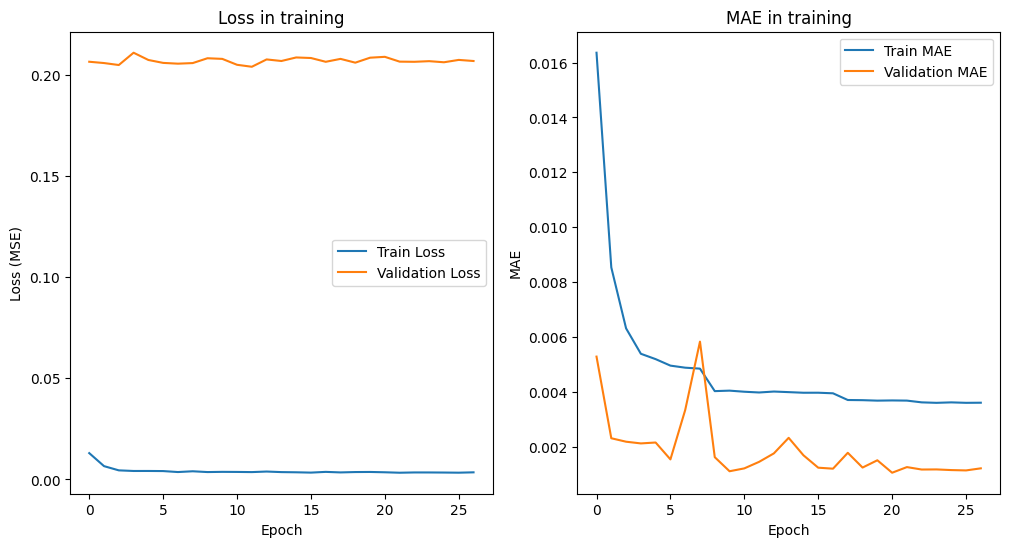

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

معیارهای ارزیابی برای Open:
MSE: 7.735629710248499e-07
RMSE: 0.0008795242867737365
MAE: 0.000782468418861664
R² Score: 0.997258239071968

معیارهای ارزیابی برای High:
MSE: 6.027060957777792e-07
RMSE: 0.0007763414814228203
MAE: 0.0005255581380395089
R² Score: 0.9978581523446041

معیارهای ارزیابی برای Low:
MSE: 1.9371235651988375e-06
RMSE: 0.0013918058647666481
MAE: 0.0012392763469884012
R² Score: 0.9931500431263752

معیارهای ارزیابی برای Close:
MSE: 1.4183200097227703e-06
RMSE: 0.0011909324119037026
MAE: 0.0008910452801879217
R² Score: 0.9949758553027758

دقت جهت برای Close: 48.503728877560654%


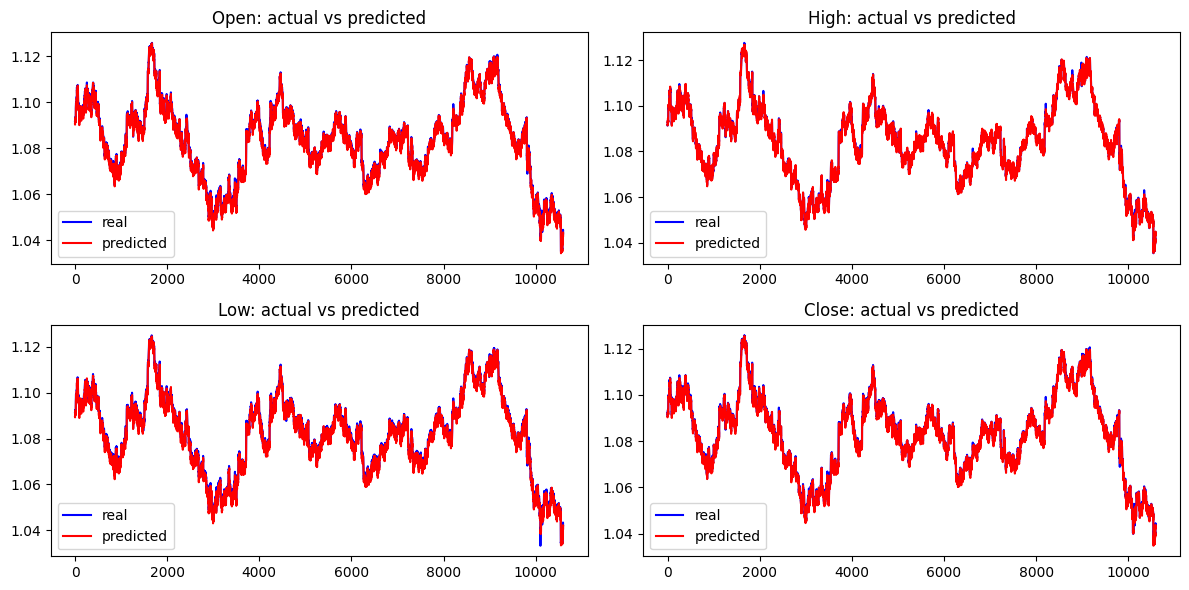

In [14]:
# 9. پیش‌بینی
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_open = scalers_outputs['Open'].inverse_transform(predictions[:, 0].reshape(-1, 1))
predictions_high = scalers_outputs['High'].inverse_transform(predictions[:, 1].reshape(-1, 1))
predictions_low = scalers_outputs['Low'].inverse_transform(predictions[:, 2].reshape(-1, 1))
predictions_close = scalers_outputs['Close'].inverse_transform(predictions[:, 3].reshape(-1, 1))

y_test_open = scalers_outputs['Open'].inverse_transform(y_test[:, 0].reshape(-1, 1))
y_test_high = scalers_outputs['High'].inverse_transform(y_test[:, 1].reshape(-1, 1))
y_test_low = scalers_outputs['Low'].inverse_transform(y_test[:, 2].reshape(-1, 1))
y_test_close = scalers_outputs['Close'].inverse_transform(y_test[:, 3].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_open, predictions_open, "Open")
calculate_metrics(y_test_high, predictions_high, "High")
calculate_metrics(y_test_low, predictions_low, "Low")
calculate_metrics(y_test_close, predictions_close, "Close")

# 12. دقت جهت برای Close
correct_directions = np.sum(np.sign(predictions_close[1:] - predictions_close[:-1]) == np.sign(y_test_close[1:] - y_test_close[:-1]))
directional_accuracy = correct_directions / (len(predictions_close) - 1)
print(f"\nدقت جهت برای Close: {directional_accuracy * 100}%")

# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(y_test_open, label='real', color='blue')
plt.plot(predictions_open, label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high, label='real', color='blue')
plt.plot(predictions_high, label='predicted', color='red')
plt.title('High: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low, label='real', color='blue')
plt.plot(predictions_low, label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close, label='real', color='blue')
plt.plot(predictions_close, label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.legend()

plt.tight_layout()
plt.show()

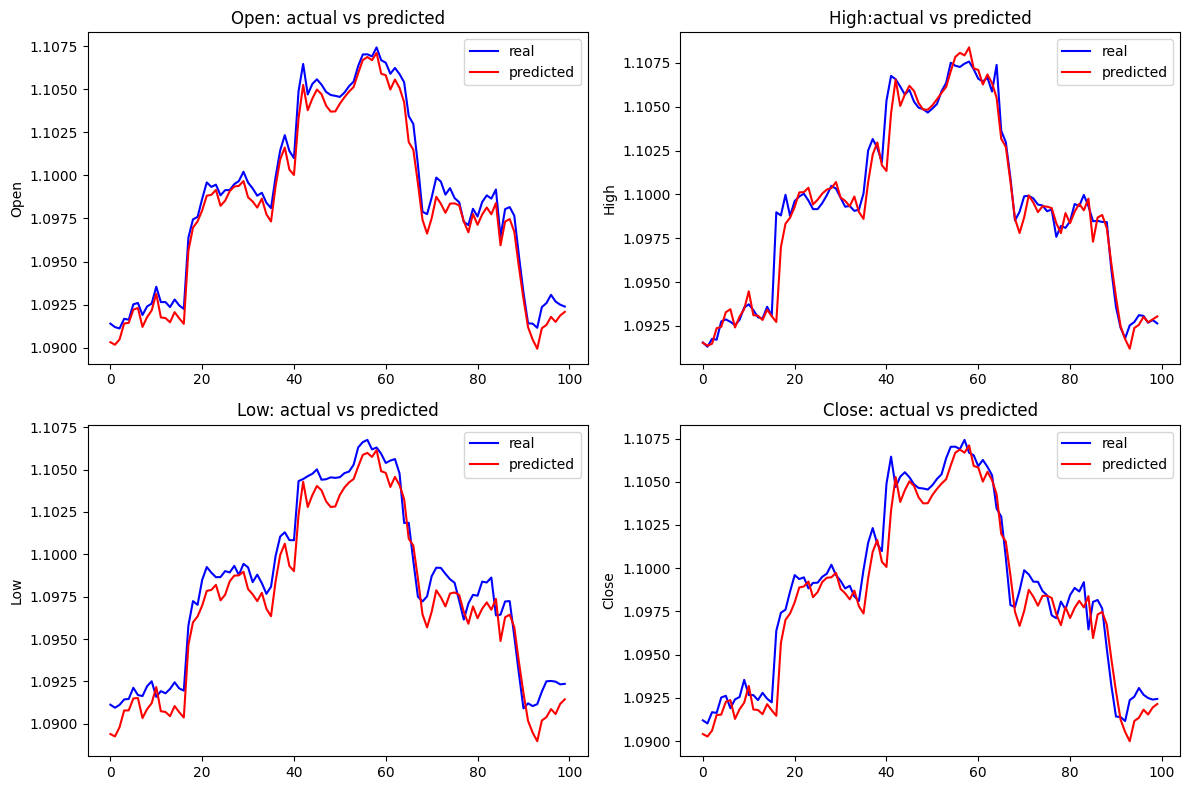

In [15]:
n_samples = 100  # تعداد نمونه‌هایی که می‌خوای نشون بدی

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(y_test_open[:n_samples], label='real', color='blue')
plt.plot(predictions_open[:n_samples], label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.ylabel('Open')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high[:n_samples], label='real', color='blue')
plt.plot(predictions_high[:n_samples], label='predicted', color='red')
plt.title('High:actual vs predicted')
plt.ylabel('High')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low[:n_samples], label='real', color='blue')
plt.plot(predictions_low[:n_samples], label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.ylabel('Low')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close[:n_samples], label='real', color='blue')
plt.plot(predictions_close[:n_samples], label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.ylabel('Close')
plt.legend()

plt.tight_layout()
plt.show()

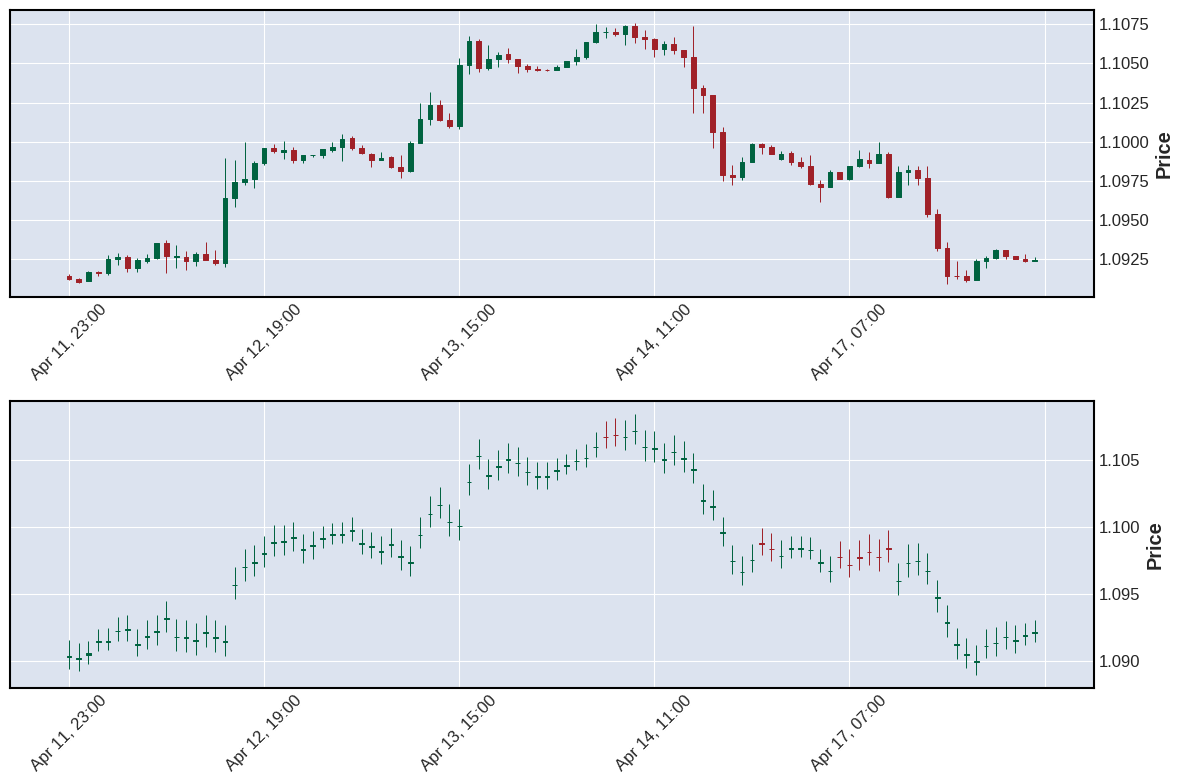

In [16]:
import mplfinance as mpf
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)
dates = data['Date'].iloc[-len(predictions):].values[:n_samples]
dates = pd.to_datetime(dates)  # تبدیل به datetime

predicted_candles = pd.DataFrame({
    'Date': dates,
    'Open': predictions_open[:n_samples].flatten(),
    'High': predictions_high[:n_samples].flatten(),
    'Low': predictions_low[:n_samples].flatten(),
    'Close': predictions_close[:n_samples].flatten()
})
predicted_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
predicted_candles.index = pd.DatetimeIndex(predicted_candles.index)

actual_candles = pd.DataFrame({
    'Date': dates,
    'Open': y_test_open[:n_samples].flatten(),
    'High': y_test_high[:n_samples].flatten(),
    'Low': y_test_low[:n_samples].flatten(),
    'Close': y_test_close[:n_samples].flatten()
})
actual_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
actual_candles.index = pd.DatetimeIndex(actual_candles.index)

# رسم کندل‌ها با استفاده از mpf.make_subplots
# به جای plt.subplots، از خود mplfinance برای مدیریت زیرنمودارها استفاده می‌کنیم
fig = mpf.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# رسم کندل‌های واقعی و پیش‌بینی‌شده
mpf.plot(actual_candles, type='candle', style='charles', ax=ax1)
mpf.plot(predicted_candles, type='candle', style='charles', ax=ax2)

# تنظیم فاصله بین زیرنمودارها
fig.tight_layout()
mpf.show()

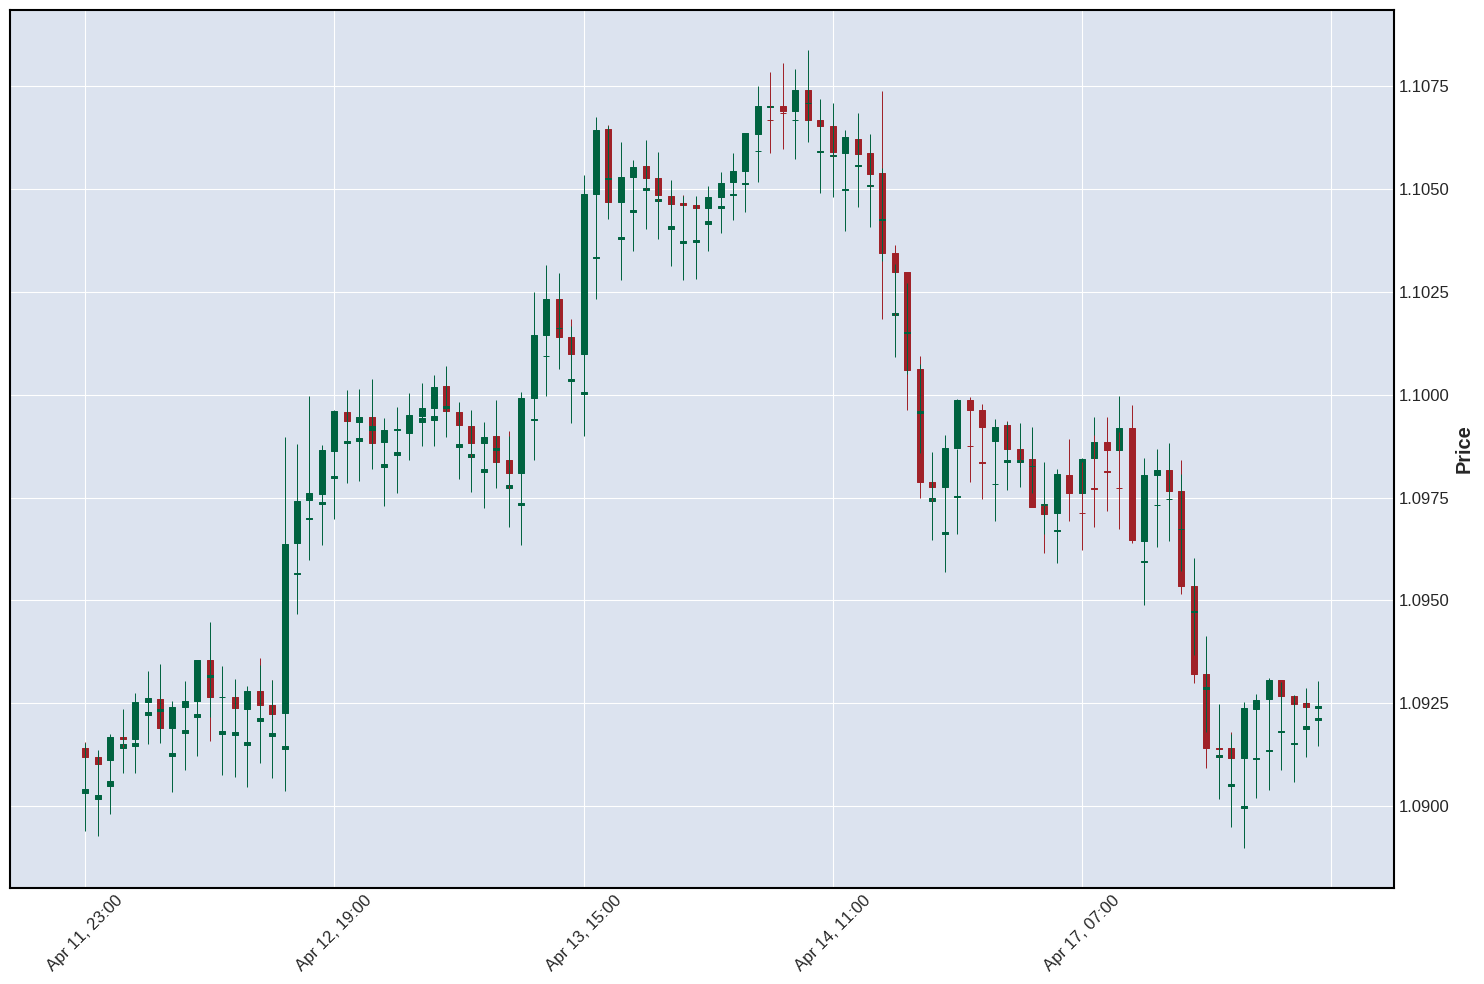

In [17]:
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)
dates = data['Date'].iloc[-len(predictions):].values[:n_samples]
dates = pd.to_datetime(dates)  # تبدیل به datetime

predicted_candles = pd.DataFrame({
    'Date': dates,
    'Open': predictions_open[:n_samples].flatten(),
    'High': predictions_high[:n_samples].flatten(),
    'Low': predictions_low[:n_samples].flatten(),
    'Close': predictions_close[:n_samples].flatten()
})
predicted_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
predicted_candles.index = pd.DatetimeIndex(predicted_candles.index)

actual_candles = pd.DataFrame({
    'Date': dates,
    'Open': y_test_open[:n_samples].flatten(),
    'High': y_test_high[:n_samples].flatten(),
    'Low': y_test_low[:n_samples].flatten(),
    'Close': y_test_close[:n_samples].flatten()
})
actual_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
actual_candles.index = pd.DatetimeIndex(actual_candles.index)

fig = mpf.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

mpf.plot(actual_candles, type='candle', style='charles', ax=ax)


# کندل‌های پیش‌بینی‌شده (پررنگ) روی همون محور
mpf.plot(predicted_candles, type='candle', style='charles', ax=ax)


# نمایش نمودار
fig.tight_layout()
mpf.show()